In [2]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim

import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa

from src.utility import EDA
eda = EDA()

In [3]:
from src.classes import DrumTrackerDataset
dataset = DrumTrackerDataset()

/home/vikram-linux/anaconda3/envs/drum-tracker/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


In [4]:
signal, label = dataset.__getitem__(0)
signal.size()

torch.Size([1, 256, 6])

In [5]:
print(label, type(label))

1 <class 'numpy.int64'>


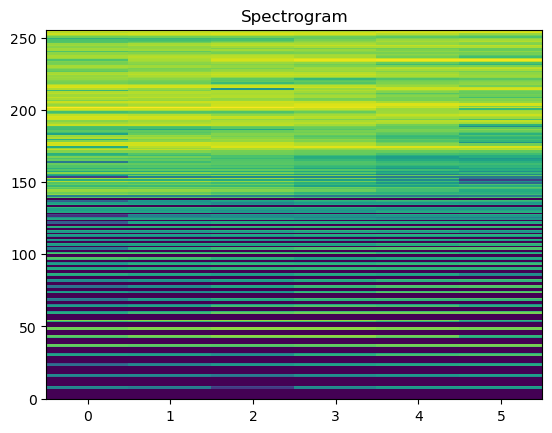

In [6]:
eda.plot_spectrogram(signal.squeeze(0))

In [7]:
from src.classes import ModelTrainer, CNN_Model
cnn_model = CNN_Model()
loss_fn = nn.CrossEntropyLoss()
optim_fn = optim.Adam(params=cnn_model.parameters(), lr=0.1)
trainer = ModelTrainer(cnn_model, loss_fn, optim_fn, dataset)


In [8]:
# trainer.train_model(EPOCHS=10)

In [9]:
mel_spec_trans = T.MelSpectrogram(
    sample_rate = 16000,
    n_fft = 256,
    hop_length = 256 // 8,
    n_mels = 512
)

/home/vikram-linux/anaconda3/envs/drum-tracker/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


In [10]:
signal, rate = torchaudio.load('data/clean/hi-hat_100.wav')
print(signal.size())
print(f'Rate = {rate}')

torch.Size([1, 160])
Rate = 16000


In [11]:
mel_spec = mel_spec_trans(signal).unsqueeze(0)
input_size = torch.tensor(mel_spec.size())
input_size

tensor([  1,   1, 512,   6])

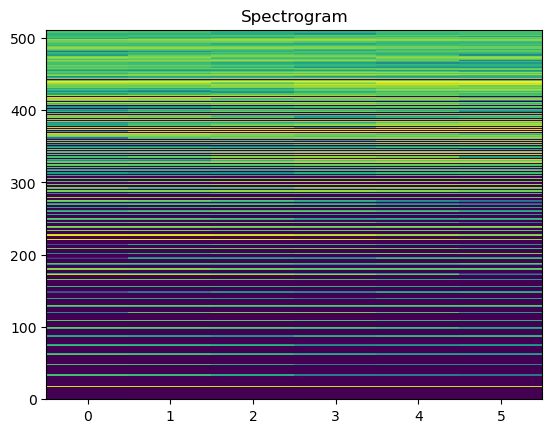

In [12]:
eda.plot_spectrogram(mel_spec.squeeze(0).squeeze(0))

Text(0.5, 1.0, 'histogram')

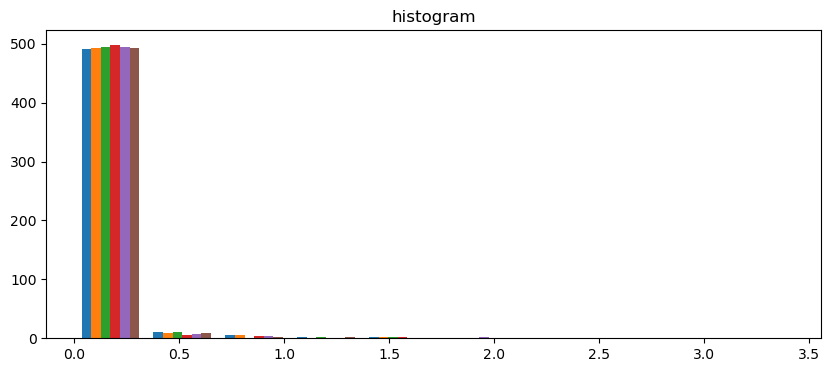

In [13]:
hist_signal = mel_spec.squeeze(0).squeeze(0).numpy()
fig, ax = plt.subplots(figsize=(10,4))
n,bins,patches = ax.hist(hist_signal, edgecolor='none')
ax.set_title("histogram")

In [14]:
conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 16,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv2 = nn.Conv2d(
            in_channels = 16,
            out_channels = 32,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv3 = nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv4 = nn.Conv2d(
            in_channels = 64,
            out_channels = 128,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

relu = nn.ReLU()
maxpool =  nn.MaxPool2d(kernel_size=2)

flatten = nn.Flatten()

output = maxpool(relu(conv1(mel_spec)))
print(f'Conv1 Ouput = {output.size()}')

output = maxpool(relu(conv2(output)))
print(f'Conv2 Ouput = {output.size()}')

output = maxpool(relu(conv3(output)))
print(f'Conv3 Ouput = {output.size()}')

output = maxpool(relu(conv4(output)))
print(f'Conv4 Ouput = {output.size()}')
print(output.size()[1] * output.size()[2] * output.size()[3])

linear_in_features = output.size()[1] * output.size()[2] * output.size()[3]
linear1 = nn.Linear(in_features=linear_in_features, out_features=128)
linear2 = nn.Linear(in_features=128, out_features=16)
linear3 = nn.Linear(in_features=16, out_features=3)

output = flatten(output)
print(f'Flatten Output = {output.size()}')

output = linear1(output)
print(f'Linear1 Output = {output.size()}')

output = linear2(output)
print(f'Linear2 Output = {output.size()}')

output = linear3(output)
print(f'Linear3 Output = {output.size()}')

Conv1 Ouput = torch.Size([1, 16, 257, 4])
Conv2 Ouput = torch.Size([1, 32, 129, 3])
Conv3 Ouput = torch.Size([1, 64, 65, 2])
Conv4 Ouput = torch.Size([1, 128, 33, 2])
8448
Flatten Output = torch.Size([1, 8448])
Linear1 Output = torch.Size([1, 128])
Linear2 Output = torch.Size([1, 16])
Linear3 Output = torch.Size([1, 3])


In [15]:
torch.softmax(output, dim=1)

tensor([[0.2862, 0.3677, 0.3461]], grad_fn=<SoftmaxBackward0>)

In [16]:
torch.softmax(output, dim=1).argmax(dim=1)

tensor([1])

## **MODEL-02**

In [17]:
conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 16,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv2 = nn.Conv2d(
            in_channels = 16,
            out_channels = 32,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

relu = nn.ReLU()
maxpool =  nn.MaxPool2d(kernel_size=2)

flatten = nn.Flatten()

output = maxpool(relu(conv1(mel_spec)))
print(f'Conv1 Ouput = {output.size()}')

output = maxpool(relu(conv2(output)))
print(f'Conv2 Ouput = {output.size()}')

print(output.size()[1] * output.size()[2] * output.size()[3])

linear_in_features = output.size()[1] * output.size()[2] * output.size()[3]
linear1 = nn.Linear(in_features=linear_in_features, out_features=2048)
linear2 = nn.Linear(in_features=2048, out_features=512)
linear3 = nn.Linear(in_features=512, out_features=64)
linear4 = nn.Linear(in_features=64, out_features=3)

output = flatten(output)
print(f'Flatten Output = {output.size()}')

output = linear1(output)
print(f'Linear1 Output = {output.size()}')

output = linear2(output)
print(f'Linear2 Output = {output.size()}')

output = linear3(output)
print(f'Linear3 Output = {output.size()}')

output = linear4(output)
print(f'Linear4 Output = {output.size()}')

Conv1 Ouput = torch.Size([1, 16, 257, 4])
Conv2 Ouput = torch.Size([1, 32, 129, 3])
12384
Flatten Output = torch.Size([1, 12384])
Linear1 Output = torch.Size([1, 2048])
Linear2 Output = torch.Size([1, 512])
Linear3 Output = torch.Size([1, 64])
Linear4 Output = torch.Size([1, 3])


In [18]:
torch.softmax(output, dim=1)

tensor([[0.3263, 0.3236, 0.3501]], grad_fn=<SoftmaxBackward0>)

# Model-03

In [19]:
conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 16,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv2 = nn.Conv2d(
            in_channels = 16,
            out_channels = 32,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv3 = nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv4 = nn.Conv2d(
            in_channels = 64,
            out_channels = 128,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

relu = nn.ReLU()
maxpool =  nn.MaxPool2d(kernel_size=2)
dropout = nn.Dropout(p=0.2)

flatten = nn.Flatten()

output = relu(conv1(mel_spec))
print(f'Conv1 Ouput = {output.size()}')

output = relu(conv2(output))
print(f'Conv2 Ouput = {output.size()}')

output = relu(conv3(output))
print(f'Conv3 Ouput = {output.size()}')

output = maxpool(relu(conv4(output)))
print(f'Conv4 Ouput = {output.size()}')

output = dropout(output)

print(output.size()[1] * output.size()[2] * output.size()[3])

linear_in_features = output.size()[1] * output.size()[2] * output.size()[3]
linear1 = nn.Linear(in_features=linear_in_features, out_features=128)
linear2 = nn.Linear(in_features=128, out_features=16)
linear3 = nn.Linear(in_features=16, out_features=3)

output = flatten(output)
print(f'Flatten Output = {output.size()}')

output = linear1(output)
print(f'Linear1 Output = {output.size()}')

output = linear2(output)
print(f'Linear2 Output = {output.size()}')

output = linear3(output)
print(f'Linear3 Output = {output.size()}')

print(torch.softmax(output, dim=1))

Conv1 Ouput = torch.Size([1, 16, 514, 8])
Conv2 Ouput = torch.Size([1, 32, 516, 10])
Conv3 Ouput = torch.Size([1, 64, 518, 12])
Conv4 Ouput = torch.Size([1, 128, 260, 7])
232960
Flatten Output = torch.Size([1, 232960])
Linear1 Output = torch.Size([1, 128])
Linear2 Output = torch.Size([1, 16])
Linear3 Output = torch.Size([1, 3])
tensor([[0.3353, 0.3539, 0.3108]], grad_fn=<SoftmaxBackward0>)


In [20]:
output

tensor([[0.2338, 0.2877, 0.1577]], grad_fn=<AddmmBackward0>)